<a href="https://colab.research.google.com/github/LimGuenTaek/pymldg-rev/blob/main/04_%EB%B6%84%EB%A5%98/4_4_GBM(Gradient_Boosting_Machine).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/Python_Machine_Learning/datasets/UCI HAR Dataset

/content/drive/MyDrive/Colab Notebooks/Python_Machine_Learning/datasets/UCI HAR Dataset


# GBM의 개요 및 실습

부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측 하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식입니다.

부스팅의 대표적인 구현은 AdaBoost(Adaptive boosting)와 그래디언트 부스트가 있습니다.

에이다 부스트(AdaBoost)는 오류 데이터에 가중치를 부여하면서 부스팅을 수행하는 대표적인 알고리즘입니다.



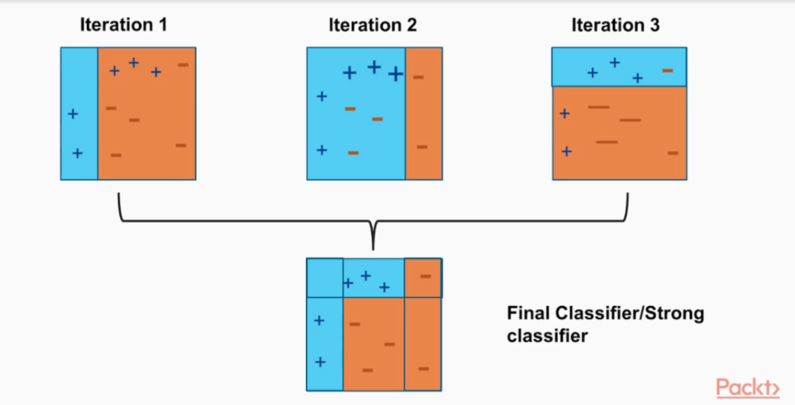

GBM(Gradient Boost Machine)도 에이다부스트와 유사하나 , 가중치 업데이트를 경사 하강법(Gradient Descent)을 이용하는 것이 큰 차이입니다. 

GBM은 CART 기반의 다른 알고리즘과 마찬가지로 분류는 물론이고 , 회귀도 가능합니다.

사이킷런은 GBM 기반의 분류를 위해서 GradientBoostingClassifier 클래스를 제공합니다.

In [4]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [5]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 800.9 초 


## GBM 하이퍼 파라미터 및 튜닝

* loss : 경사 하강법에서 사용할 비용 함수를 지정합니다. 특별한 이유가 없으면 기본값인 'deviance'를 그대로 적용합니다.

* learning_rate : GBM이 학습을 진행할 때 마다 적용하는 학습률 입니다.

* n_estimator : weak learner의 개수입니다. weak learner가 순차적으로 오류를 보정하므로 개수가 많을수록 예측 성능이 일정 수준까지는 좋아질 수 있습니다. 하지만 개수가 많을수록 수행 시간이 오래걸립니다. 기본값은 100입니다.

* subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율입니다. 기본값은 1이며 , 이는 전체 학습 데이터를 기반으로 학습한다는 의미입니다. 과적합이 염려되는 경우 subsample을 1보다 작은 값으로 설정합니다.

In [8]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 80.1min finished


최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도: 0.9013


In [9]:
scores_df = pd.DataFrame(grid_cv.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score',
'split0_test_score', 'split1_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score
0,"{'learning_rate': 0.05, 'n_estimators': 100}",0.899619,4,0.886561,0.912677
1,"{'learning_rate': 0.05, 'n_estimators': 500}",0.901251,1,0.889554,0.912949
2,"{'learning_rate': 0.1, 'n_estimators': 100}",0.900027,2,0.887650,0.912405
3,"{'learning_rate': 0.1, 'n_estimators': 500}",0.899891,3,0.887106,0.912677


In [10]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9396


GBM은 과적합에도 강한 뛰어난 예측 성능을 가진 알고리즘입니다. 하지만 수행 시간이 오래 걸린다는 단점이 있습니다. GBM이 처음 소개된 이후에 많은 알고리즘이 GBM을 기반으로 새롭게 만들어지고 있습니다.

이중 머신러닝 세계에서 가장 각광을 받고 있는 두 개의 그래디언트 부스팅 기반 ML 패키지는 XGBoost와 LightGBM입니다.